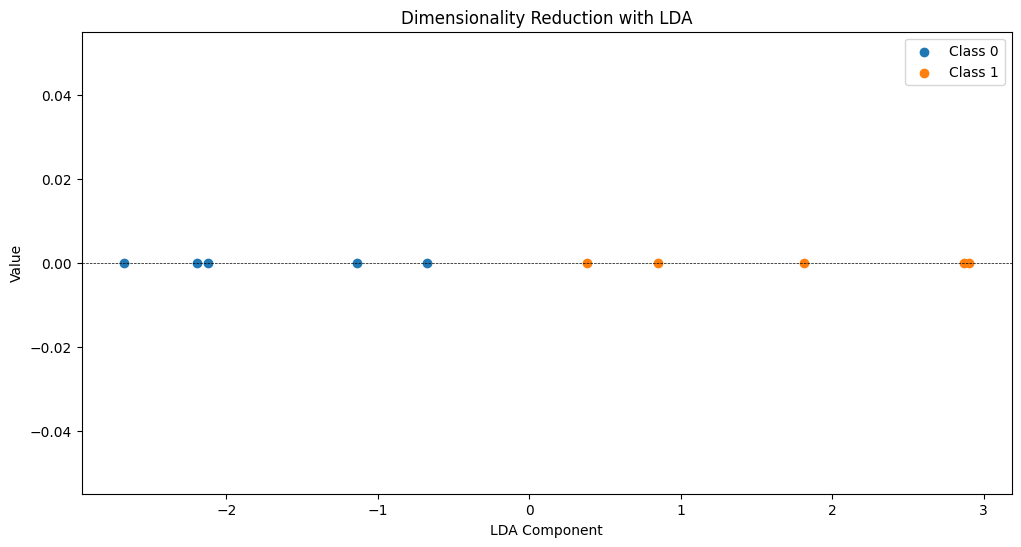

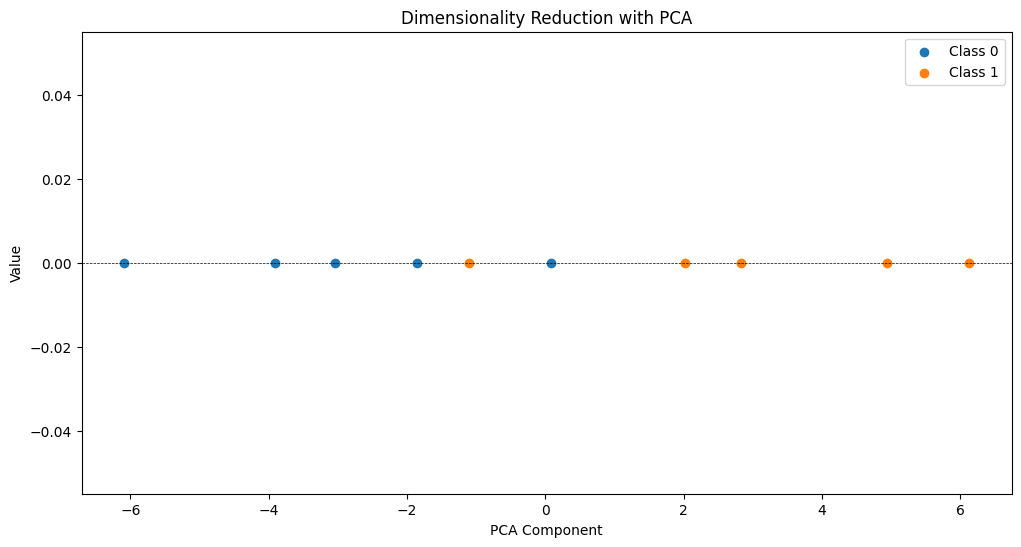

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Given dataset
data = {
    'x': [1, 3, 4, 5, 7, 6, 9, 10, 12, 13],
    'y': [2, 5, 3, 6, 5, 2, 4, 1, 3, 6],
    'Class': [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
}
df = pd.DataFrame(data)

# Separate features and labels
X = df[['x', 'y']].values
y = df['Class'].values

# LDA for dimensionality reduction
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

# PCA for dimensionality reduction
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

# Add the reduced dimensions to the dataframe
df['LDA'] = X_lda
df['PCA'] = X_pca

# Plot LDA results with best-fit line
plt.figure(figsize=(12, 6))
for label in np.unique(y):
    class_data = df[df['Class'] == label]
    plt.scatter(class_data['LDA'], [0] * len(class_data), label=f'Class {label}')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('Dimensionality Reduction with LDA')
plt.xlabel('LDA Component')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot PCA results with best-fit line
plt.figure(figsize=(12, 6))
for label in np.unique(y):
    class_data = df[df['Class'] == label]
    plt.scatter(class_data['PCA'], [0] * len(class_data), label=f'Class {label}')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('Dimensionality Reduction with PCA')
plt.xlabel('PCA Component')
plt.ylabel('Value')
plt.legend()
plt.show()


Consider the 128- dimensional feature vectors (d=128) given in the “gender.csv” file. (2 classes, male and female)
a) Use LDA to reduce the dimension from d to d’. (Here d=128)
b) Choose the direction “W‟ to reduce the dimension d’ (select appropriate d’).
c) Use d’ features to classify the test cases (use any classification algorithm taught in class, Bayes classifier, minimum distance classifier, and so on).


Dataset Specifications:
Total number of samples = 800
Number of classes = 2 (labeled as “male” and “female”)
Samples from “1 to 400” belongs to class “male”
Samples from “401 to 800” belongs to class “female”
Number of samples per class = 400
Number of dimensions = 128
Use the following information to design classifier:
Number of test cases (first 10 in each class) = 20
Number of training feature vectors ( remaining 390 in each class) = 390
Number of reduced dimensions = d’ (map 128 to d’ features vector)


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Read the dataset
gender_df = pd.read_csv('gender.csv')

# Rename the columns for better readability
gender_df.rename(columns={'Unnamed: 1': 'Label'}, inplace=True)
gender_df.drop(columns=['Unnamed: 0'], inplace=True)

# Separate the features (X) and the labels (y)
X = gender_df.drop(columns=['Label']).values
y = gender_df['Label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Function to perform LDA (Linear Discriminant Analysis)
def LDA(X_train, X_test, y_train, y_test):
    # Calculate the mean vectors for each class
    mean_vectors = []
    for label in np.unique(y_train):
        mean_vectors.append(np.mean(X_train[y_train == label], axis=0))

    # Calculate the within-class scatter matrix Sw
    Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
    for label, mean_vector in zip(np.unique(y_train), mean_vectors):
        class_scatter = np.zeros((X_train.shape[1], X_train.shape[1]))
        class_data = X_train[y_train == label]
        class_scatter += np.dot((class_data - mean_vector).T, (class_data - mean_vector))
        Sw += class_scatter

    # Calculate the between-class scatter matrix Sb
    overall_mean = np.mean(X_train, axis=0)
    Sb = np.zeros((X_train.shape[1], X_train.shape[1]))
    for mean_vector, label in zip(mean_vectors, np.unique(y_train)):
        n = X_train[y_train == label].shape[0]
        mean_diff = (mean_vector - overall_mean).reshape(-1, 1)
        Sb += n * np.dot(mean_diff, mean_diff.T)

    # Solve the eigenvalue problem for (Sw^-1) * Sb
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

    # Ensure that eigenvalues and eigenvectors are real
    eigvals = np.real(eigvals)
    eigvecs = np.real(eigvecs)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, sorted_indices]

    # Select the top eigenvectors corresponding to the largest eigenvalues
    # Here, we choose d' = 1 for dimensionality reduction
    W = eigvecs_sorted[:, :1]

    # Project the training and test data onto the new LDA space
    X_train_lda = np.dot(X_train, W)
    X_test_lda = np.dot(X_test, W)

    return X_train_lda, X_test_lda, y_train, y_test

# Apply LDA to reduce the dimensionality
X_train_lda, X_test_lda, y_train, y_test = LDA(X_train, X_test, y_train, y_test)

# Use Naive Bayes classifier on the reduced LDA features
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_lda, y_train)

# Predict on the test data
y_pred = nb_classifier.predict(X_test_lda)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy of the model is: {accuracy:.2f}%")

# Print the predictions for each sample
for i, (true, pred) in enumerate(zip(y_test, y_pred)):
    print(f"Sample {i+1}: True label = {'Male' if true == 0 else 'Female'}, Predicted = {'Male' if pred == 0 else 'Female'}")


Accuracy of the model is: 90.00%
Sample 1: True label = Female, Predicted = Female
Sample 2: True label = Female, Predicted = Female
Sample 3: True label = Female, Predicted = Female
Sample 4: True label = Female, Predicted = Female
Sample 5: True label = Female, Predicted = Female
Sample 6: True label = Female, Predicted = Female
Sample 7: True label = Female, Predicted = Female
Sample 8: True label = Female, Predicted = Female
Sample 9: True label = Female, Predicted = Female
Sample 10: True label = Female, Predicted = Female
Sample 11: True label = Female, Predicted = Female
Sample 12: True label = Female, Predicted = Female
Sample 13: True label = Female, Predicted = Female
Sample 14: True label = Female, Predicted = Female
Sample 15: True label = Female, Predicted = Female
Sample 16: True label = Female, Predicted = Female
Sample 17: True label = Female, Predicted = Female
Sample 18: True label = Female, Predicted = Female
Sample 19: True label = Female, Predicted = Female
Sample 

Fisherfaces- Face classification using LDA (40 classes)
a) Use the following “face.csv” file to classify the faces of 40 different people using LDA.
b) Do not use the in-built function for implementing LDA.
c) Use appropriate classifier taught in class (use any classification algorithm taught in class like Bayes classifier, minimum distance classifier, and so on)
d) Refer to the following link for a description of the dataset: 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
face_df = pd.read_csv('face.csv')
face_df.rename({'target': 'Label'}, axis = 1, inplace = True)

In [3]:
import numpy as np
import pandas as pd

def LDA_multiclass(X):

    #Find total mean
    total_mean = np.mean(X.drop(columns=['Label']), axis=0)

    classes = X['Label'].unique()
    Sw = np.zeros((X.shape[1] - 1, X.shape[1] - 1))  # (features, features)
    Sb = np.zeros((X.shape[1] - 1, X.shape[1] - 1))

    for class_label in classes:
        class_i = X[X['Label'] == class_label]
        class_i = class_i.drop(columns=['Label'])
        mean_i = np.mean(class_i, axis=0).values
        
        # Within-class scatter
        Sw_i = (class_i - mean_i).T @ (class_i - mean_i)
        Sw += Sw_i

        # Between-class scatter
        mean_diff = (mean_i - total_mean)
        mean_diff = np.array(mean_diff)
        mean_diff = mean_diff.reshape(-1, 1)
        Sb += (mean_diff @ mean_diff.T)

    #Find eigen vectors and eigen values
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw) @ Sb)
    eigvals, eigvecs = eigvals.real, eigvecs.real


    # Sort eigenvalues and select top n - 1 eigenvectors
    idx = eigvals.argsort()[::-1]
    eigvecs = eigvecs[:, idx]
    weights = eigvecs[:, :len(classes) - 1]
    print("The weights for the LDA are:\n", weights)

    # Projecting data onto new LDA space
    df_reduced = X.drop(columns=['Label']) @ weights
    return pd.DataFrame(df_reduced)





In [5]:
# Example usage
print(face_df.head(5))
print(face_df.shape)
face_reduced = LDA_multiclass(face_df)
print(face_reduced.head(5))
print(face_reduced.shape)

          0         1         2         3         4         5         6  \
0  0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1  0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2  0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3  0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4  0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.677686  0.690083  0.685950  ...  0.669422  0.652893  0.661157  0.475207   
1  0.702479  0.710744  0.702479  ...  0.157025  0.136364  0.148760  0.152893   
2  0.685950  0.702479  0.698347  ...  0.132231  0.181818  0.136364  0.128099   
3  0.404959  0.483471  0.516529  ...  0.636364  0.657025  0.685950  0.727273   
4  0.714876  0.723140  0.731405  ...  0.161157  0.177686  0.173554  0.177686   

       4091      4092      4093      4094      4095  Label  
0  0.13

In [8]:
X_train, X_test, y_train, y_test = train_test_split(face_reduced, face_df['Label'], test_size=0.2, random_state=42) 

# classify the testing data using Nearest Neighbor Classifier and print the accuracy 
knn = KNeighborsClassifier(n_neighbors = 1)

knn.fit(X_train, y_train)

pred = knn.predict(X_test)

print("Accuracy of the model using Nearest Neighbor is: ", accuracy_score(y_test, pred)*100, "%")


Accuracy of the model using Nearest Neighbor is:  100.0 %
